# Jan 28, 2026: create graphs

conda env: gt

In [1]:
import os
import sys
import numpy as np 
import pandas as pd 
from glob import glob
from nilearn.maskers import NiftiLabelsMasker
import nibabel as nib
import re
from pathlib import Path
import dill as pickle
from tqdm import tqdm
import graph_tool.all as gt 
from scipy.stats import entropy, zscore
from joblib import Parallel, delayed
from itertools import product, combinations
from sklearn.covariance import GraphicalLasso

# plotting
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

# import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS(): pass

args = ARGS()

args.SEED = 100
np.random.seed(args.SEED)

In [3]:
PARC_DESC = f'NEWMAX_ROIs_final_gm_100_2mm' #f'NEWMAX_ROIs_final_gm_104_2mm' #f'ABA_ROIs_final_gm_36'
BASE_path = f'/home/govindas/lab-data/aba'
ROI_path = (
    f'{BASE_path}/{PARC_DESC}'
)
os.makedirs(ROI_path, exist_ok=True)

TS_file = f'{BASE_path}/{PARC_DESC}/roi_timeseries_df.pkl'

In [4]:
args.ANALYSIS = 'trial-end'
args.WINDOW = np.arange(5, 9+1)

In [5]:
GRAPH_DEFS = [f'constructed']
GRAPH_METHODS = [f'pearson'] # [f'pearson', f'mutualinfo']
THRESHOLDINGS = [f'signed', f'unsigned']
EDGE_DEFS = [f'binary', f'weighted']
EDGE_DENSITIES = [10, 20, 30] #[10, 15, 20, 25]
LAYER_DEFS = [f'individual'] #, f'multilayer']
DATA_UNITS = [f'grp', f'sub']

In [6]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub' #'grp'

In [7]:
with open(TS_file, 'rb') as f:
    df_ts = pickle.load(f)

In [8]:
df_ts

,sub,run,play_highR,play_highT,play_lowR,play_lowT
0,ABA602,0,"[[[0.772962768005994, 0.027128934891122423, 0....","[[[-0.22216339232870685, -0.8715079098898862, ...","[[[-1.1985321709328278, 0.041593399590052475, ...","[[[-0.6169540222793665, -0.584467025376894, 0...."
1,ABA602,1,"[[[1.1173576693259635, -0.2217349101987449, -0...","[[[-0.19174514160697773, -0.9168454800565413, ...","[[[0.9844849130226946, -1.1735009016608238, 0....","[[[-0.18210486246262952, 0.4615230025295883, -..."
2,ABA602,2,"[[[0.7224823005491996, -1.232327703964998, -1....","[[[0.5143397802567918, 0.618786984916922, 0.59...","[[[-0.27410037279459076, 1.7791556151943184, 0...","[[[-0.17605798691418004, -1.6670195788136595, ..."
3,ABA602,3,"[[[0.6060753756080832, 0.030511490935999017, 1...","[[[0.5118322605892102, -0.5687441156299206, 0....","[[[2.0073727011988827, 0.8519876481499351, -0....","[[[1.7259845947417558, -0.2617681132978361, 0...."
4,ABA602,4,"[[[0.7048385378742246, 1.170696939016591, -0.0...","[[[0.07378615655297532, 0.16645096988440666, -...","[[[-2.0634615522278827, 0.4515583534688838, -0...","[[[-1.3673473297442815, -1.938318666035096, -0..."
...,...,...,...,...,...,...
551,ABA698,3,"[[[1.9175054354527417, 1.6791657771806088, -0....","[[[1.0256932401251329, 1.3491476826325373, -1....","[[[0.786889509044422, 0.42677399604852617, 0.8...","[[[-0.752089264423914, 0.17886576126547857, -0..."
552,ABA698,4,"[[[-0.12859276435366637, -0.449248882560284, 0...","[[[0.918491914056718, 1.0005948080863685, -1.6...","[[[0.15984301986820365, 0.896461123764391, 0.7...","[[[1.088403393808012, 0.4620084527880611, -0.0..."
553,ABA698,5,"[[[1.1564697271695907, 1.7968656758357011, -1....","[[[-0.2176409725844696, -0.18274899067333014, ...","[[[1.7264885696308547, 0.5610064082907323, -1....","[[[-0.09215275016581848, 1.154275645686303, -1..."
554,ABA698,6,"[[[0.7674825916508768, -0.45682488600785814, 0...","[[[0.3325173317030818, -1.8246649669575834, -1...","[[[0.6672593665267801, -0.8989456612365428, 0....","[[[-0.1429292054785982, 0.28019817115044415, -..."


In [9]:
def get_analysis_ts(x, ANALYSIS_WINDOW):
    if isinstance(x, (int, np.integer)):
        return x 
    
    if isinstance(x, str):
        return x
    
    x = x[:, ANALYSIS_WINDOW, :]
    x = np.concatenate(x, axis=0) # over trials: num_time x num_rois
    return x

In [10]:
df_ts = df_ts.map(lambda x: get_analysis_ts(x, args.WINDOW))
df_ts

,sub,run,play_highR,play_highT,play_lowR,play_lowT
0,ABA602,0,"[[-0.8259167401033636, -0.6435987266009695, -0...","[[0.3463390479375461, 0.7980636703072387, 0.88...","[[-0.817415770263336, 1.3262546822577215, 1.02...","[[1.4165305806766777, 0.23771173645289145, 0.1..."
1,ABA602,1,"[[-0.599446830981558, -0.6553910954079124, -0....","[[0.8555485168789682, 0.46055695720014, -0.491...","[[0.9135131633828916, 0.32912789699083805, -1....","[[0.43710265605442866, -1.1829581415364903, -0..."
2,ABA602,2,"[[2.4434816356092717, -0.9608207548514474, -0....","[[-1.1676813650745557, 0.2745358636152076, 1.4...","[[0.09539666009004248, -0.3920435593930575, 0....","[[0.4628359011479405, -1.8287374227292694, -0...."
3,ABA602,3,"[[0.2996339325701366, -0.0005954668794402519, ...","[[0.0956212243673586, -0.6746839170631479, -0....","[[1.3064020160823928, -0.08208676793879535, -1...","[[0.12490618436172833, -1.6157447231869273, -0..."
4,ABA602,4,"[[0.8367843619258041, -0.0396079436638313, -1....","[[0.4386293498257488, 0.5231449490574536, 1.16...","[[-0.5113833325033286, 0.39281831052585775, 0....","[[0.32224925669989163, -0.546053483009803, 0.4..."
...,...,...,...,...,...,...
551,ABA698,3,"[[1.5906854639687311, -0.19493722759629573, -0...","[[0.0387183342215904, -0.26906482516532976, -1...","[[-0.20558152712740319, 1.3371594585458682, -0...","[[-1.2698621713405123, -2.464002917375486, -0...."
552,ABA698,4,"[[-0.3427537854406064, -0.4050121293837791, -1...","[[-0.6360166061559082, 0.10559868279901545, -0...","[[1.5361242137005366, 0.8283950164174955, -0.6...","[[-0.011722873260652376, -2.076689503078756, -..."
553,ABA698,5,"[[-0.10732020856439055, -1.211237653130859, -1...","[[-1.4434517523043584, -1.0382992131001894, -0...","[[-1.1728330029776173, -0.1509779618649889, -0...","[[-0.1664882935385103, 0.6914516670277832, 0.0..."
554,ABA698,6,"[[0.11940833871138182, 0.3556163720989084, -1....","[[-0.3670247416213356, 0.13395228753152394, 0....","[[-0.4651402482640099, -0.40317348554088434, -...","[[1.574855057951881, -0.37398807326915967, 0.9..."


In [11]:
conds = [col for col in df_ts.columns if 'play' in col]
conds

['play_highR', 'play_highT', 'play_lowR', 'play_lowT']

In [12]:
df_sub_ts = []
for sub, sub_group in df_ts.groupby('sub'):
    row = dict(sub=[sub])
    for cond in conds:
        row[cond] = [np.concatenate(sub_group[cond].to_list(), axis=0)] # num_time x num_rois
    df_sub_ts.append(pd.DataFrame(row))
df_sub_ts = pd.concat(df_sub_ts).reset_index(drop=True)

In [13]:
df_sub_ts

,sub,play_highR,play_highT,play_lowR,play_lowT
0,ABA602,"[[-0.8259167401033636, -0.6435987266009695, -0...","[[0.3463390479375461, 0.7980636703072387, 0.88...","[[-0.817415770263336, 1.3262546822577215, 1.02...","[[1.4165305806766777, 0.23771173645289145, 0.1..."
1,ABA603,"[[-0.03364494600191365, -1.4329972908061743, -...","[[0.062478943548733505, -1.0307123511844398, -...","[[0.15364904173187852, 0.2063333343475782, 1.4...","[[-0.19953095742398536, 0.3247886307803699, -0..."
2,ABA604,"[[0.06814724101311224, 0.7092625301556684, 0.9...","[[0.3152316805445027, 1.743057758532477, 0.026...","[[-1.0095177148613685, -1.5636340434348672, -1...","[[0.4349396112269818, 1.897914008379196, 0.308..."
3,ABA606,"[[-1.347164545690519, -0.7009208100898564, -1....","[[-2.052899061993264, -1.7976652539888462, -1....","[[0.06687590798593213, -0.6982898013440108, 1....","[[-0.5867382152952555, -1.3408944870776789, -1..."
4,ABA607,"[[-1.1742029511694987, -1.4824113071138765, -1...","[[-0.1688852324020361, -0.4034354344454464, 0....","[[1.590991527518958, 3.203221519388949, 0.4798...","[[1.4339743448457039, 0.7225230232160854, 0.77..."
...,...,...,...,...,...
65,ABA692,"[[-1.3180680846820185, -0.016798447411005057, ...","[[-0.2764499536499058, -1.20753246250861, -0.0...","[[-0.16804170272466137, 0.6546050200384066, 0....","[[-1.503527586315293, -0.5686774742790118, -0...."
66,ABA693,"[[0.6352479884297737, 1.1022938663542166, 0.34...","[[-1.334959893941935, 0.15515118981079787, -0....","[[-0.4881788506136555, -0.6205259184443359, 0....","[[-1.228269412923412, -0.9183278338020505, -0...."
67,ABA695,"[[-0.32145545743114406, -0.21429567879010938, ...","[[0.5874514817071108, -1.081851190696476, -0.2...","[[0.4023378761679766, -0.05743496868666887, -0...","[[1.6256131602325767, 2.179237936114396, 1.661..."
68,ABA697,"[[-0.5278840694661727, -0.03645267600552169, -...","[[1.5727338807409783, 1.063658407226196, -0.01...","[[-0.6591532112819996, -1.4477188483817836, 0....","[[1.8315730913370663, 0.5634620008065601, 1.14..."


In [14]:
ROI_DATA_path = (
    f'{ROI_path}'
    f'/analysis-{args.ANALYSIS}'
    f'/ts'
)
os.makedirs(ROI_DATA_path, exist_ok=True)
df_sub_ts.to_pickle(f'{ROI_DATA_path}/desc-ts.pkl')

In [15]:
with open(f'{ROI_DATA_path}/desc-ts.pkl', 'rb') as f:
    df_ts = pickle.load(f)
df_ts

,sub,play_highR,play_highT,play_lowR,play_lowT
0,ABA602,"[[-0.8259167401033636, -0.6435987266009695, -0...","[[0.3463390479375461, 0.7980636703072387, 0.88...","[[-0.817415770263336, 1.3262546822577215, 1.02...","[[1.4165305806766777, 0.23771173645289145, 0.1..."
1,ABA603,"[[-0.03364494600191365, -1.4329972908061743, -...","[[0.062478943548733505, -1.0307123511844398, -...","[[0.15364904173187852, 0.2063333343475782, 1.4...","[[-0.19953095742398536, 0.3247886307803699, -0..."
2,ABA604,"[[0.06814724101311224, 0.7092625301556684, 0.9...","[[0.3152316805445027, 1.743057758532477, 0.026...","[[-1.0095177148613685, -1.5636340434348672, -1...","[[0.4349396112269818, 1.897914008379196, 0.308..."
3,ABA606,"[[-1.347164545690519, -0.7009208100898564, -1....","[[-2.052899061993264, -1.7976652539888462, -1....","[[0.06687590798593213, -0.6982898013440108, 1....","[[-0.5867382152952555, -1.3408944870776789, -1..."
4,ABA607,"[[-1.1742029511694987, -1.4824113071138765, -1...","[[-0.1688852324020361, -0.4034354344454464, 0....","[[1.590991527518958, 3.203221519388949, 0.4798...","[[1.4339743448457039, 0.7225230232160854, 0.77..."
...,...,...,...,...,...
65,ABA692,"[[-1.3180680846820185, -0.016798447411005057, ...","[[-0.2764499536499058, -1.20753246250861, -0.0...","[[-0.16804170272466137, 0.6546050200384066, 0....","[[-1.503527586315293, -0.5686774742790118, -0...."
66,ABA693,"[[0.6352479884297737, 1.1022938663542166, 0.34...","[[-1.334959893941935, 0.15515118981079787, -0....","[[-0.4881788506136555, -0.6205259184443359, 0....","[[-1.228269412923412, -0.9183278338020505, -0...."
67,ABA695,"[[-0.32145545743114406, -0.21429567879010938, ...","[[0.5874514817071108, -1.081851190696476, -0.2...","[[0.4023378761679766, -0.05743496868666887, -0...","[[1.6256131602325767, 2.179237936114396, 1.661..."
68,ABA697,"[[-0.5278840694661727, -0.03645267600552169, -...","[[1.5727338807409783, 1.063658407226196, -0.01...","[[-0.6591532112819996, -1.4477188483817836, 0....","[[1.8315730913370663, 0.5634620008065601, 1.14..."


In [16]:
# normalized mutual information
def optimal_bin_size(ts, method="fd"):
    """Computes the optimal number of bins for fMRI time series based on the selected method."""
    N = len(ts)  # Number of time points

    if method == "sturges":
        return int(np.ceil(np.log2(N) + 1))
    
    elif method == "rice":
        return int(np.ceil(2 * N ** (1/3)))

    elif method == "fd":  # Freedman-Diaconis Rule
        iqr = np.percentile(ts, 75) - np.percentile(ts, 25)
        bin_width = (2 * iqr) / (N ** (1/3))
        return int(np.ceil((np.max(ts) - np.min(ts)) / bin_width))

    elif method == "scott":  # Scott's Rule
        std_dev = np.std(ts)
        bin_width = (3.5 * std_dev) / (N ** (1/3))
        return int(np.ceil((np.max(ts) - np.min(ts)) / bin_width))
    
def compute_joint_density(ts1, ts2, bins=100):
    hist_xy, x_edges, y_edges = np.histogram2d(ts1, ts2, bins=bins, density=True)
    hist_x = np.histogram(ts1, bins=x_edges, density=True)[0]
    hist_y = np.histogram(ts2, bins=y_edges, density=True)[0]

    p_xy = hist_xy / np.sum(hist_xy) # joint density
    p_x = hist_x / np.sum(hist_x) # marginal of x
    p_y = hist_y / np.sum(hist_y) # marginal of y

    return p_xy, p_x, p_y

def compute_nmi(ts1, ts2, bins=100):
    # densities
    p_xy, p_x, p_y = compute_joint_density(ts1, ts2, bins)
    
    # entropies
    Hxy = entropy(p_xy.flatten(), base=2) # joint entropy: same as summing `- p_xy log(p_xy)` over each (x, y)
    Hx = entropy(p_x, base=2) 
    Hy = entropy(p_y, base=2)

    # mutual information
    Ixy = Hx + Hy - Hxy

    # normalize MI
    Ixy = Ixy / np.sqrt(Hx * Hy) if Hx > 0 and Hy > 0 else 0
    return Ixy

def compute_nmi_matrix(ts, bins=100, n_jobs=10):
    num_rois = ts.shape[1]
    nmi_matrix = np.zeros((num_rois, num_rois))

    def compute_nmi_pair(i, j):
        return compute_nmi(ts[:, i], ts[:, j], bins)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_nmi_pair)(i, j)
        for i, j in combinations(range(num_rois), 2)
    )

    # fill nmi matrix
    for idx, (i, j) in enumerate(combinations(range(num_rois), 2)):
        nmi_matrix[i, j] = results[idx]
        nmi_matrix[j, i] = results[idx]
    
    return nmi_matrix

In [17]:
def compute_fc(args, ts):
    if isinstance(ts, str): 
        return ts
    
    # ts.shape : time x rois
    if args.GRAPH_METHOD == 'pearson':
        fc = np.corrcoef(ts.T)
        # fc -= np.diag(np.diag(fc))
    if args.GRAPH_METHOD == 'partial':
        model = GraphicalLasso(alpha=0.01)
        model.fit(ts)
        fc = -model.precision_ # inverse covariance matrix
    if args.GRAPH_METHOD == 'mutualinfo':
        bins = optimal_bin_size(ts)
        fc = compute_nmi_matrix(ts, bins=bins, n_jobs=10)
    
    np.fill_diagonal(fc, 0)
    return np.nan_to_num(fc)

def threshold_fc(args, fc_matrix):
    keep_ratio = args.EDGE_DENSITY / 100
    
    fc_thresh = np.zeros_like(fc_matrix)

    # Compute percentile threshold
    fc_values = fc_matrix[np.triu_indices_from(fc_matrix, k=1)]  # Extract upper triangle
    if args.THRESHOLD=='signed':
        fc_values = fc_values  # Consider values with their signs
    if args.THRESHOLD=='unsigned':
        fc_values = np.abs(fc_values) # Consider values without their signs
    percentile_thresh = np.percentile(fc_values, 100 * (1 - keep_ratio))

    # Apply percentile threshold
    mask = fc_matrix >= percentile_thresh

    # construct edges by their definition
    if args.EDGE_DEF == 'binary':
        fc_thresh = mask
    elif args.EDGE_DEF == 'weighted':
        fc_thresh = fc_matrix * mask

    return fc_thresh


In [18]:
args.eps = 1e-7

def fisher_z(args, r):
    if isinstance(r, str): return r
    r = np.clip(r, -1+args.eps, 1-args.eps)
    return np.arctanh(r)

def tidy_corr(R):
    R = 0.5 * (R + R.T)
    np.fill_diagonal(R, 0.0)
    return R

def z_to_fc(z):
    if isinstance(z, str): return z
    fc = np.tanh(z)
    fc = tidy_corr(fc)
    fc = np.round(fc, decimals=3)
    return fc

In [19]:
def average_z(df):
    avg_df = dict()
    for col in df.columns:
        Z = df[col].to_list()
        if isinstance(Z[0], str):
            avg_df[col] = ['grp']
        else:
            Z = np.stack(Z)
            Z_ = np.mean(Z, axis=0)
            avg_df[col] = [Z_]
    avg_df = pd.DataFrame(avg_df)
    return avg_df

In [20]:
df_fc = df_ts.map(lambda ts: compute_fc(args, ts))
df_fc

,sub,play_highR,play_highT,play_lowR,play_lowT
0,ABA602,"[[0.0, 0.16839523074668977, 0.0339606537037106...","[[0.0, 0.2773010502595657, 0.0352886160362814,...","[[0.0, 0.2516526665797265, 0.1980914065845191,...","[[0.0, 0.20153595353515727, 0.0702244453098477..."
1,ABA603,"[[0.0, 0.7300729582600504, 0.578395899703947, ...","[[0.0, 0.4692424368201641, 0.4270731985056221,...","[[0.0, 0.5538985619389695, 0.41260301123860804...","[[0.0, 0.6089827115472133, 0.590931464884263, ..."
2,ABA604,"[[0.0, 0.365274201456006, 0.21343563024306736,...","[[0.0, 0.3273164458231468, 0.18723302012171006...","[[0.0, 0.4007881090216859, 0.2788085480025651,...","[[0.0, 0.5143689899013996, 0.4371101108795737,..."
3,ABA606,"[[0.0, 0.3016894709804102, 0.44971880983462836...","[[0.0, 0.4914069676705765, 0.5498167026460418,...","[[0.0, 0.3084574423041616, 0.3401419570513813,...","[[0.0, 0.5058510581506706, 0.5586080041383269,..."
4,ABA607,"[[0.0, 0.6650385209637524, 0.34514466406635036...","[[0.0, 0.5084400256365642, 0.17932896476694032...","[[0.0, 0.5742210504328052, 0.26806239223940315...","[[0.0, 0.49050889032046563, 0.3269403469803822..."
...,...,...,...,...,...
65,ABA692,"[[0.0, 0.633197056946754, 0.5211719241008513, ...","[[0.0, 0.48030651786263634, 0.3373366475061913...","[[0.0, 0.6278113316821254, 0.41146491497644105...","[[0.0, 0.562158865469635, 0.2457284530461013, ..."
66,ABA693,"[[0.0, 0.6288821180441757, 0.4016464082499881,...","[[0.0, 0.7339257530844344, 0.33353925594163886...","[[0.0, 0.6825694621580247, 0.33004474770545106...","[[0.0, 0.7556145749276194, 0.4077071948327892,..."
67,ABA695,"[[0.0, 0.4285002420232825, 0.408344567065408, ...","[[0.0, 0.5654912291355058, 0.5387940410031926,...","[[0.0, 0.5751941678972948, 0.42963275322182015...","[[0.0, 0.507219713499642, 0.5697216043501664, ..."
68,ABA697,"[[0.0, 0.5809815885376892, 0.4596225732377813,...","[[0.0, 0.5283572511090779, 0.42641203879857337...","[[0.0, 0.5277907373003351, 0.3600297033957388,...","[[0.0, 0.6258131397672262, 0.4455840345064977,..."


In [21]:
df_z = df_fc.map(lambda fc: fisher_z(args, fc))
df_grp_z = average_z(df_z)
df_grp_fc = df_grp_z.map(z_to_fc)
df_grp_fc

,sub,play_highR,play_highT,play_lowR,play_lowT
0,grp,"[[0.0, 0.538, 0.371, 0.37, 0.517, 0.356, 0.1, ...","[[0.0, 0.537, 0.343, 0.35, 0.501, 0.337, 0.087...","[[0.0, 0.528, 0.359, 0.337, 0.495, 0.348, 0.08...","[[0.0, 0.55, 0.373, 0.355, 0.509, 0.345, 0.125..."


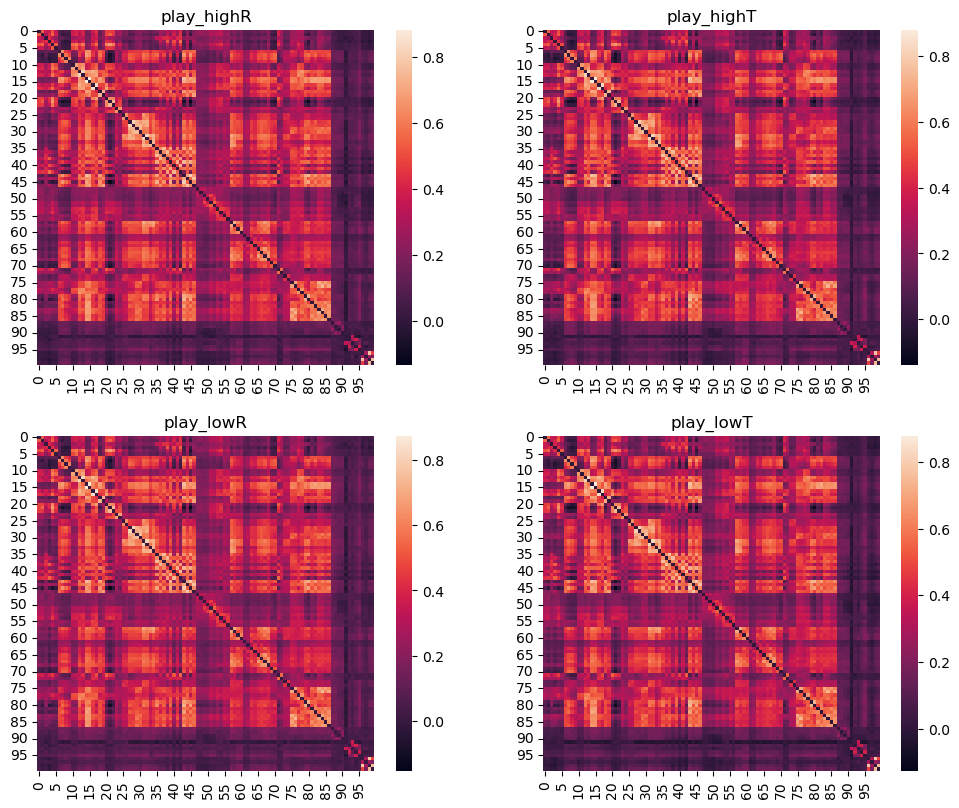

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(2*5, 2*4))
fig.tight_layout(h_pad=3, w_pad=3)

for idx, col in enumerate(df_grp_fc.columns):
    if col == 'sub': continue
    r, c = (idx-1) // 2, (idx-1) % 2
    ax = axs[r, c]
    ax.set_title(col)
    sns.heatmap(df_grp_fc.at[0, col], ax=ax)

In [23]:
def make_graph(fc):
    fc = np.tril(fc, k=-1)
    edges = np.where(fc)
    edge_list = list(zip(*[*edges, fc[edges]]))
    g = gt.Graph(
        edge_list,
        eprops=[('weight', 'double')],
        directed=False, 
    )
    return g

def save_graph(g, identity, GRAPH_path):
    file = '_'.join([identity] + [f'desc-graph.gt.gz'])
    file = f'{GRAPH_path}/{file}'
    g.save(file)
    return file

In [24]:
def save_graphs(args, df, ITERS):
    for (
        THRESHOLD, 
        EDGE_DEF,
        EDGE_DENSITY,
        COND,
    ) in ITERS:
        args.THRESHOLD = THRESHOLD
        args.EDGE_DEF = EDGE_DEF
        args.EDGE_DENSITY = EDGE_DENSITY
        args.COND = COND
        ROI_RESULTS_path = (
            f'{ROI_path}'
            f'/analysis-{args.ANALYSIS}'
            f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
            f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
            f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}/cond-{args.COND.split('_')[-1]}'
        )
        GRAPH_path = f'{ROI_RESULTS_path}/graphs'
        os.makedirs(GRAPH_path, exist_ok=True)
        
        for idx_row, row in df.iterrows():
            sub = row['sub']
            identity = f'sub-{sub}'
            fc = row[args.COND]
            fc = threshold_fc(args, fc)
            g = make_graph(fc)
            file = save_graph(g, identity, GRAPH_path)

In [25]:
ITERS = product(
    THRESHOLDINGS,
    EDGE_DEFS,
    EDGE_DENSITIES,
    conds,
)
save_graphs(args, df_fc, ITERS)